In [ ]:
from properties import LYRICS_ROOT_FOLDER, CSV_FOLDER
from pathlib import Path
from fuzzywuzzy import fuzz
from datetime import datetime
from tqdm import tqdm # Progressbar
from utils import create_connection, execute_script, find_first, make_folder_if_not_exists
from models.Song import Song
from models.SongStructure import SongStructure
from models.Section import Section
import logging
import csv
import re
import json
import pandas as pd
import os
import numpy as np

SONG_PROCESSING_FOLDER = make_folder_if_not_exists(LYRICS_ROOT_FOLDER / "extraction/new2")

# 1. Parse lyrics.jl with help of artist_info.json

In the lyrics.jl file, each line looks like this 

```json
{"song": "Kendrick-lamar-swimming-pools-drank-lyrics", "lyrics": " ... "}
```

We want to parse the song name as provided in this file into (1) artist and (2) song title.

In artist_info.json, we have 
```json
{
  "url_name": "Kendrick-lamar",
  "followers": 23782,
  "roles": [
    "Verified Artist",
    "Contributor"
  ],
  "iq": 39144,
  "songs": [
    "Kendrick-lamar-humble-lyrics",
    "A-ap-rocky-fuckin-problems-lyrics",
    "Kendrick-lamar-maad-city-lyrics",
    "Kendrick-lamar-swimming-pools-drank-lyrics",
    "..."
  ]
}
```

So ideally, we want to recognize that the artist of the song is "Kendrick Lamar", and the song title is "Humble". And we can do so by crossreferencing lyrics.jl with artist_info.json.

Another strategy is that, of the songs of which this mapping fails, we extract the longest common prefix from the song url (the "song" attribute of lyrics.jl) and we can then say with some confidence that this will be the artist name, since we know that the url starts with the artist name.

In [ ]:
artist_names : list[str] = [] # listing all the distinct artist names from artist_info 
with open(Path(LYRICS_ROOT_FOLDER, "artist_info.json"), 'r') as artist_info:
    while (line := artist_info.readline()):
        data = json.loads(line)
        artist = data['url_name']

        if artist in artist_names:
            continue
    
        artist_names.append(artist)


# buckets of artist name per first char (lowercase)
# buckets are sorted lengthwise (longest first) to make greedy artist name matching faster
first_chars = set(map(lambda name: name[0].lower(), artist_names))
processed_artist_names = {first_char : sorted([artist_name for artist_name in artist_names if artist_name.lower().startswith(first_char)], key=len, reverse=True) for first_char in first_chars}

# Now we crossreference lyrics.jl lines with these artists to the best of our ability
songs : list[Song] = []
not_found_artists : list[str] = []
disregarded_songs : list[str] = []

Song.ID = 0 # Reset so that we can run this cell multiple times and starting with id 0

with open(Path(LYRICS_ROOT_FOLDER, "lyrics.jl"), 'r') as lyrics:
    while (line := lyrics.readline()):
        data = json.loads(line)
        _song_info = data['song']

        # There are also "annotations" in the lyrics.jl file but we're not interested in them.
        if not _song_info.endswith('lyrics'): 
            disregarded_songs.append(_song_info)
            continue

        # infer the artist name by taking a look whether there is an exact match with one of the artists in the appropriate bucket
        artist_bucket_to_search = processed_artist_names[_song_info[0].lower()]
        matched_artist = find_first(lambda artist_name: _song_info.startswith(artist_name), artist_bucket_to_search)

        if matched_artist is None:
            not_found_artists.append(_song_info)
            continue

        # extract song title from the song info (given that we now know the artist name):
        # example: " ".join('artist-name-this-is-the-song-title-lyrics'.split('artist-name')[1].split('-')[1:-1]).strip() -> "this is the song title"
        title = " ".join(_song_info.split(matched_artist)[1].split('-')[1:-1]).strip()
        songs.append(Song(_song_info, title, matched_artist.replace('-', " ").strip(), data['lyrics']))

print(f"Infered song data for {len(songs)} songs")
if len(not_found_artists) > 0:
    print(f"Failed for {len(not_found_artists)} due to artist mapping not found")
assert len(list(filter(lambda info: not info.endswith('annotated'), disregarded_songs))) == 0, "All disregarded songs should be annotations"
if len(disregarded_songs) > 0:
    print(f"Disregarded {len(disregarded_songs)} entries (annotations)")
# Strategy to infer new arists names: extract the longest common prefix of the  song (that will be the artist probably)

# 1. bucket per first char again to make the process easier (again, also sorted by length -- largest first)
not_found_first_chars = set(map(lambda name: name[0].lower(), not_found_artists))
not_found_artists_bucketed = {first_char : sorted([artist_name for artist_name in not_found_artists if artist_name.lower().startswith(first_char)], key=len, reverse=True) for first_char in not_found_first_chars}
artist_still_not_found : list[str] = []

matches = {}
extracted_artists = set()

for info in not_found_artists:

    # Maybe we have already processed the artist
    match = find_first(lambda x: info.replace('-', " ").strip().startswith(x), sorted(extracted_artists, key=len, reverse=True))
    if match is not None:
        matches[info] = match
        continue
    
    bucket_longest_first = sorted(not_found_artists_bucketed[info.lower()[0]], key=len, reverse=True)
    
    bucket_size = len(bucket_longest_first)
    # We cannot leverage other songs to guess the artist, because this is the only one in there
    if bucket_size == 1:
        artist_still_not_found.append(info)
        continue

    # Check matches with others and assign a confidence score (percentage)
    others = bucket_longest_first
    others.remove(info)
    others_ranked = {other : 0 for other in others}
    for other in others:
        word_pairs = zip(info.split('-'), other.split('-'))
        for info_word, other_word in word_pairs:
            if info_word != other_word:
                break
            others_ranked[other] += 1
            
    ## Now we sort by ranked and see how much they have in common
    largest_common_prefix_word_count = max(others_ranked.values())
    others_matching = list(filter(lambda x: others_ranked[x] == largest_common_prefix_word_count, others))
    # Now we assign the artist to these songs
    resolved_artist_name = " ".join(info.split('-')[:largest_common_prefix_word_count]).strip()
    matches[info] = resolved_artist_name
# Show the found artists
reversed_matches = {}
for song, artist in matches.items():
    if artist not in reversed_matches.keys():
        reversed_matches[artist] = []
    reversed_matches[artist].append(song)

for artist in sorted(reversed_matches.keys()):
    print(artist)
    for song in reversed_matches[artist]:
        print('\t', song)

new_songs : list[Song] = []
# Update the data with the custom found
with open(Path(LYRICS_ROOT_FOLDER, "lyrics.jl"), 'r') as lyrics:
    while (line := lyrics.readline()):
        data = json.loads(line)
        song_info = data['song']
        if song_info not in matches.keys() or matches[song_info] == '':
            continue
        artist = matches[song_info]
        title = " ".join(song_info.split(artist.replace(" ", "-"))[1].split('-')[1:-1]).strip()
        new_songs.append(Song(song_info, title, artist.replace('-', " ").strip(), data['lyrics']))

print(f"Added {len(new_songs)} new songs")
all_songs = songs + new_songs


# -------------------------------------------------------------------------------------------------------------
# MANUAL CORRECTION
# -------------------------------------------------------------------------------------------------------------
print("STARTING MANUAL CORRECTION")

# Manually correcting song
filter_url_name = lambda name : (lambda s : s.genius_url == name)
bruno_mars_song1 = find_first(filter_url_name("Bruno-mars-thats-what-i-like-gucci-mane-remix-lyrics"), new_songs)
bruno_mars_song2 = find_first(filter_url_name("Bruno-mars-thats-what-i-like-partynextdoor-remix-lyrics"), new_songs)
lil_krystalll_song = find_first(filter_url_name("Lil-krystalll-tic-tac-demo-lyrics"), new_songs)
lil_silva_song = find_first(filter_url_name("Lil-silva-right-for-you-lyrics"), new_songs)

bruno_mars_song1.artist = "Bruno mars"
bruno_mars_song1.title = "thats what i like gucci many remix"

bruno_mars_song2.artist = "Bruno mars"
bruno_mars_song2.title = "thats what i like partynextdoor remix"

lil_krystalll_song.artist = "Lil krystalll"
lil_krystalll_song.title = "tic tac demo"

lil_silva_song.artist = "Lil silva"
lil_silva_song.title = "right for you"


assert not any(s.artist == "Bruno mars thats what i like" for s in all_songs)

print(f"Fixed {4} songs that were not mapped entirely correctly manually")


# Manually correcting artist names here 
artist_corrections = {
    'A ap rocky': 'A$ap rocky',
    'A ap mob': 'A$ap mob',
    'A ap ferg': 'A$ap ferg',
    'A ap twelvyy': 'A$ap twelvyy',
    'A ap nast': 'A$ap nast'
}

amt_artist_name_corrections = 0
for song in all_songs:
    if song.artist in artist_corrections:
        song.artist = artist_corrections[song.artist]
        amt_artist_name_corrections += 1

print(f"Fixed {amt_artist_name_corrections} artist names manually")

manual_url_maps = {
    "Caye-easy-lyrics": ("Caye", "easy"),
    "Trav-fuck-and-smoke-lyrics": ("Trav", "fuck and smoke"),
    "Amil-4-da-fam-lyrics": ("Amil", "4 da fam"),
    "B-smyth-leggo-lyrics": ("B-smyth", "leggo"),
    "Chevralet-ss-bad-mother-fucker-bmf-lyrics": ("Chevralet-ss", "bad mother fucker bmf"),
    "Cb4-straight-outta-locash-lyrics": ("Cb4", "straight outta locash"),
    "Terra-g-clock-work-lyrics": ("Terra-g", "clock work"),
    "Quincy-exotic-lyrics": ("Quincy", "exotic"),
    "Quin-over-again-lyrics": ("Quin", "over again"),
    "Koryn-hawthorne-bright-fire-lyrics": ("Koryn-hawthorne", "bright fire"),
    "Acid-drop-king-im-a-problem-lyrics": ("Acid-drop-king", "im a problem"),
    "Kda-just-say-lyrics": ("Kda", "just say"),
    "Trey-smith-find-you-somewhere-lyrics": ("Trey-smith", "find you somewhere"),
    "Bwa-ron-all-i-ever-wanted-lyrics": ("Bwa-ron", "all i ever wanted"),
    "Ambre-preach-lyrics": ("Ambre", "preach"),
    "Artistes-divers-vald-sofiane-kalash-criminel-biffty-et-suikon-blaze-ad-en-live-dans-planete-rap-lyrics":
        ("Artistes-divers-vald-sofiane-kalash-criminel-biffty-et-suikon-blaze-ad", "en live dans planete rap"),
    "Catch-lungs-gotta-kill-this-lyrics": ("Catch-lungs", "gotta kill this"),
    "Fedy-only-thing-i-know-lyrics": ("Fedy", "only thing i know"),
    "Batgang-dangerous-lyrics": ("Batgang", "dangerous"),
    "Tamia-officially-missing-you-midi-mafia-mix-with-rap-lyrics": ("Tamia", "officially missing you midi mafia mix with rap"),
    "Kold-i-love-the-holy-grail-lyrics": ("Kold", "i love the holy grail"),
    "Tamar-braxton-the-one-lyrics": ("Tamar-braxton", "the one"),
    "Tracey-lee-keep-your-hands-high-lyrics": ("Tracey-lee", "keep your hands high"),
    "Cashflow-harlem-want-my-love-back-lyrics": ("Cashflow-harlem", "want my love back"),
    "A1billionaire-rookie-of-the-year-lyrics": ("A1billionaire", "rookie of the year"),
    "Louis-mattrs-oops-x-wus-good-lyrics": ("Louis-mattrs", "oops x wus good"),
    "T-la-rock-and-jazzy-jay-its-yours-lyrics": ("T-la-rock-and-jazzy-jay", "its yours"),
    "Bando-jonez-sex-you-remix-lyrics": ("Bando-jonez", "sex you remix"),
    "1wayfrank-make-it-happen-lyrics": ("1wayfrank", "make it happen"),
    "Teamcakee-post-to-be-cake-mix-lyrics": ("Teamcakee", "post to be cake mix"),
    "Amy-schumer-milk-milk-lemonade-lyrics": ("Amy-schumer", "milk milk lemonade"),
    "L-devine-peer-pressure-lyrics": ("L-devine", "peer pressure"),
    "Ar-side-god-lyrics": ("Ar", "side god"),
    "Vell-oakland-lyrics": ("Vell", "oakland"),
    "Cdot-honcho-02-shit-remix-lyrics": ("Cdot-honcho", "02 shit remix"),
    "Fekky-way-too-much-lyrics": ("Fekky", "way too much"),
    "Ar15-cant-see-me-again-lyrics": ("Ar15", "cant see me again"),
    "Yaprak-asimov-save-me-lyrics" : ("Yaprak-asimov", "save-me"),
    "Usda-white-girl-remix-lyrics": ("Usda", "white-girl-remix")
}

# Manually correcting the stuff 
manual_songs = []
with open(Path(LYRICS_ROOT_FOLDER, "lyrics.jl"), 'r') as lyrics:
    while (line := lyrics.readline()):
        data = json.loads(line)
        genius_url = data['song']
        if genius_url not in manual_url_maps.keys():
            continue

        artist, title = manual_url_maps[genius_url]
        manual_songs.append(Song(genius_url, title, artist.replace('-', " ").strip(), data['lyrics']))

all_songs += manual_songs
print(f"Added {len(manual_songs)} songs manually")
print(f"In total, we have {len(all_songs)} songs")


# Check that no songs are left unmapped
all_mapped_urls = set(map(lambda s: s.genius_url, all_songs))
unmapped=0
with open(Path(LYRICS_ROOT_FOLDER, "lyrics.jl"), 'r') as lyrics:
    while (line := lyrics.readline()):
        data = json.loads(line)
        genius_url = data['song']
        if not genius_url.endswith("annotated") and genius_url not in all_mapped_urls:
            print("Unmapped URL:", genius_url)
            unmapped += 1
    
    print(f"{unmapped} unmapped urls")
assert unmapped == 0, f"There are still {unmapped} urls left unprocessed!"

In [ ]:
# Write the songs to a csv file:
with open(Path(SONG_PROCESSING_FOLDER, "lyrics_tracks.tsv"), 'w') as f:
    writer = csv.writer(f, delimiter="\t")
    writer.writerow(["track_id", "artist_name", "track_name", "genius_url"])
    for song in all_songs:
        writer.writerow([song.id, song.artist, song.title, song.genius_url])


# 2. Crossreference the data: Fuzzy matching
## How to link the LFM2B dataset to this extracted data?

We have extracted song artists and titles for which we have the lyrics available from lyrics.jl.
These are now neatly written to a tsv file where each song also has an ID. 

So, the idea is to create a new file in which we link tracks by their ID in the LFM2B dataset and their ID in the genius lyrics dataset. 

The matching process is inherently inprecise, as tracks might not all be represented in the same way in both datasets. 
Therefore, we do "fuzzy matching" per song on both the artist as well as the track name. 

So each song from the genius lyrics database (GL) matches to zero or more artists in LFM2B and to zero or more track names in LFM2B. 

Then we will assign a confidence score for the artist and for the track name using a fuzzy matching library `fuzzywuzzy`. This yields a score \[0-100\] (percentage overlap; capitalization ignored).

We simply rank the matches on their score (highest score = rank 1).



In [ ]:
# We only consider the tracks where we could have lyrics (non-instrumental)

con, cursor = create_connection("lfm2b")
cursor.execute(r"""
               create materialized view if not exists track_non_instrumental as select * from track natural join artist where track_name not ilike '%instrumental%';
               create index if not exists tni_track_name_idx on track_non_instrumental(track_name)
               """)
con.commit()
print("Created track_non_instrumental")


class LFM2BMatch:
    def __init__(
        self,
        song,
        lfm2b_artist_id,
        lfm2b_artist_name,
        artist_confidence,
        lfm2b_track_id,
        lfm2b_track_name,
        track_confidence,
    ):
        self.song = song
        self.lfm2b_artist_id = lfm2b_artist_id
        self.lfm2b_artist_name = lfm2b_artist_name
        self.lfm2b_track_id = lfm2b_track_id
        self.lfm2b_track_name = lfm2b_track_name
        self.artist_confidence = artist_confidence
        self.track_confidence = track_confidence

    def __repr__(self):
        return f"{self.lfm2b_artist_name} - {self.lfm2b_track_name}"


matches: list[LFM2BMatch] = []
non_matched: list[Song] = []
errors: list[tuple[Song, Exception]] = []


def setup_logger(root_folder=SONG_PROCESSING_FOLDER, logger_name='main_logger') -> logging.Logger :
    """
    Creates a logger with the given name that logs to `lfm2b-genius-mapping_{timestamp}.log` in the specified folder

    Args:
        root_folder : folder where the logfile will be placed. Must be an existing folder. The default is the global `SONG_PROCESSING_FOLDER`
        logger_name : name of the logger. The default is `main_logger`. Useful to distinguish loggers when multithreading. 
    
    Returns:
        logger : The created logger
    """
    timestamp = datetime.now().strftime("%Y-%m-%dT%H_%M_%S")
    MAPPING_LOG_PATH = Path( root_folder, f"lfm2b-genius-mapping_{timestamp}.log")

    logger = logging.getLogger(logger_name)
    logger.setLevel(logging.INFO)
    logger.propagate = False 

    if logger.hasHandlers():
        logger.handlers.clear()
    file_handler = logging.FileHandler(MAPPING_LOG_PATH, encoding='utf-8')
    formatter = logging.Formatter("%(levelname)s - %(asctime)s: %(message)s", datefmt="%d-%m-%Y,%H:%M:%S")
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)
    return logger


def similarity_score(a: str, b: str) -> int:
    """Return a score [0-100] on how similar `a` is to `b` using the Levenshtein distance. Casing is ignored."""
    return fuzz.ratio(a.lower(), b.lower())


def find_best_track_match(
    song: Song, artists: list, tracks: list, write_function, logger
) -> LFM2BMatch | None:
    """
    Extracts the best match of GL song to LFM2b track according to the procedure descibred in the above cell.
    Given a song (GLDB), matched artists (LFM2B) and matched tracks (LFM2B), ranks the matches and returns the best ranked match if possible.
    If no tracks are matched in the first place, then no match can be made, so `None` is returned.

    Matches are directly written with the `write_function` and the process is logged to file.

    Args:
        song : GL song to find a matching LFM2b track to
        artists : List of likely LFM2b artist matches in the format [(artist_id, artist_name), ...]
        tracks : List of likely LFM2b track matches in the format [(track_id, track_name, artist_id, artist_name), ...]
        write_function : Function that takes in a `LFM2BMatch` object or `None` and writes it to file (or handles it in any other way deemed fit)
        logger : Logger to log the matching process with
    
    Returns:
        match : `LFM2BMatch` object with the best GL <-> LFM2b match, or `None` if no match could be made. 
    """

    # Create the ranking

    artist_name_ranking = []
    for artist_id, artist_name in artists:
        score = similarity_score(song.artist, artist_name)
        artist_name_ranking.append(
            (
                song.artist,
                artist_id,
                artist_name,
                score
            )
        )

    track_name_ranking = []
    for track_id, track_name, artist_id, artist_name in tracks:
        track_name_ranking.append(
            (
                song.title,
                track_id,
                track_name,
                artist_id,
                artist_name,
                similarity_score(song.title, track_name),
            )
        )

    artist_name_ranking.sort(key=lambda x: x[3], reverse=True)
    track_name_ranking.sort(key=lambda x: x[5], reverse=True)

    LIMIT = 10  # limit the amount of logged rankings for file size purposes
    logger.info("\t artist ranking")
    for artist_ranking in artist_name_ranking[:LIMIT]:
        logger.info("\t\t %s", artist_ranking)

    logger.info("\t track ranking")
    for track_ranking in track_name_ranking[:LIMIT]:
        logger.info("\t\t %s", track_ranking)

    logger.info("\t verdict")

    best_match: LFM2BMatch | None = None  # We assume no match (for example if there are no eligible tracks)

    # Ideally, we have the best ranked track (name) with the highest best ranked artist name
    found_match = False
    if len(track_name_ranking) > 0 and len(artist_name_ranking) > 0:
        for ranked_track in track_name_ranking:
            if found_match:
                break
            for ranked_artist in artist_name_ranking:
                if ranked_track[3] == ranked_artist[1]: # If the artist of the track is the best ranked matched artist, then we pre-emptively say we have a match.
                    best_match = LFM2BMatch(
                        song,
                        lfm2b_artist_id=ranked_artist[1],
                        lfm2b_artist_name=ranked_artist[2],
                        artist_confidence=ranked_artist[-1],
                        lfm2b_track_id=ranked_track[1],
                        lfm2b_track_name=ranked_track[2],
                        track_confidence=ranked_track[-1],
                    )
                    found_match = True
                    break
    elif len(track_name_ranking) > 0:
        best_ranked_track = track_ranking[0]
        # We have only track information, so just get the best track
        best_match = LFM2BMatch(
            song,
            lfm2b_artist_id=best_ranked_track[3],
            lfm2b_artist_name=best_ranked_track[4],
            artist_confidence=0,
            lfm2b_track_id=best_ranked_track[1],
            lfm2b_track_name=best_ranked_track[2],
            track_confidence=best_ranked_track[-1],
        )

    logger.info("\t\t %s", best_match)
    write_function(
        best_match
    )  # write the match to file, note that an exception will be raised when there is no match found (None). This is caught in the error logfile on purpose.


def do_song_mapping(songs, cursor, logger, results_folder=SONG_PROCESSING_FOLDER, artist_cache={}):
    """
    Encapsulates the entire process of mapping GL songs to LFM2b tracks.

    Args:
        songs: List of `Song` objects representing the GL songs that should be matched to LFM2b tracks.
        cursor: Cursor to the 'lfm2b' postgres database
        logger: Logger to log the process with
        results_folder: Folder to which the mapping process will be written (log, errors and results). Must be a pre-existing folder. Defaults to the global `SONG_PROCESSING_FOLDER`
        artist_cache: Dictionary serving as cache in the matching process, reducing the need for expensive database queries. 

    """
    global last_song_id
    start = songs[0].id
    end = songs[-1].id
    with open(results_folder / f"errors_{start}-{end}.tsv", "w") as error_file:
        error_file.write("track_id\ttrack\terror\n")
        mapping_path = Path(results_folder, f"lfm2b_genius_track_mapping_{start}-{end}.tsv")
        assert (not mapping_path.exists()), f"WARNING. You are about to overwrite this file {mapping_path}"
        with open(mapping_path, "w", encoding="utf8") as f:
            writer = csv.writer(f, delimiter="\t")
            writer.writerow(
                [
                    "lfm2b_track_id",
                    "genius_lyrics_track_id",
                    "artist_confidence",
                    "track_confidence",
                ]
            )

            def write_function(match : LFM2BMatch | None):
                if match is None:
                    raise RuntimeError("None type has no attribute lfm2b_track_id")
                writer.writerow([match.lfm2b_track_id, match.song.id, match.artist_confidence, match.track_confidence])

            for i in tqdm(range(len(songs))):
                song = songs[i]
                try:
                    last_song_id = song.id
                    logger.info(
                        "Computing match for song %d: %s - %s",
                        song.id,
                        song.artist,
                        song.title,
                    )

                    if song.title.strip() == "" or song.artist.strip() == "":
                        logger.info("\tSkipping due to empty title or artist")
                        raise RuntimeError("Empty song artist or title")  # To collect this in the error_file, we raise exception
                    
                    # Shortcut: only lookup artist if we have not already cached them
                    if song.artist not in artist_cache.keys():
                        cursor.execute(f"SELECT artist_id, artist_name FROM artist WHERE artist_name ilike '%{song.artist}%'")
                        artists = cursor.fetchall()
                        artist_cache[song.artist] = artists
                    else:
                        logger.info("\tUsing cache for artist")
                        artists = artist_cache[song.artist]

                    cursor.execute(f"SELECT track_id, track_name, artist_id, artist_name FROM track_non_instrumental WHERE track_name ilike '%{song.title}%'")
                    tracks = cursor.fetchall()

                    if len(tracks) == 0:
                        logger.warning("\t No matches for this track, skipping...")

                    # Discard the result, because the result is also written to file (this process takes 50+ hrs, so we reconstruct the mapping from these files later)
                    _ = find_best_track_match(song, artists, tracks, write_function, logger)
                except Exception as e:
                    error_file.write(f"{song.id}\t{song}\t{e}\n")
                    errors.append((song, e))


# -------------------------------------------------------------------------------------------------------------------------------------------------------
# SETUP
# --------------------------------------------------------------------------------------------------------------------------------------------------------
START_SONG_ID = 0 # Inclusive
END_SONG_ID = -1  # Inclusive
last_song_id = None
RESULTS_FOLDER = make_folder_if_not_exists(SONG_PROCESSING_FOLDER/"single_threaded")
#-----------------------------------------------------------------------------------------------------------------------------------------------------------

if (END_SONG_ID - START_SONG_ID) < 0:
    con.close()
    raise RuntimeError("No songs selected for mapping")

print("Starting...")

logger = setup_logger(RESULTS_FOLDER)
songs_to_map = list(filter( lambda s: (s.id >= START_SONG_ID and s.id <= END_SONG_ID), all_songs))
do_song_mapping(songs_to_map, cursor, logger, results_folder=RESULTS_FOLDER)
logger.handlers.clear() # release the files from the logger
con.close()

print(f"Had {len(errors)} errors")
print(f"Last song id {last_song_id}")  # Useful for monitoring the process.

## Or use multithreading for processing...

In [ ]:
# assert False, "Set True if multithreading is wanted"

import threading

THREADS = 10

all_songs.sort(key=lambda s: s.id)
all_song_ids = list(map(lambda s : s.id, all_songs))

assert all(a <= b for a, b in zip(all_song_ids, all_song_ids[1:])), "IDs should be sorted!"
min_song_id, max_song_id = 32400, 37447
assert all_songs[-1].id == max_song_id, "Final id not matching"

print(f"{datetime.now()} - Starting multithreaded processing of songs {min_song_id} through {max_song_id} on {THREADS} threads.")

chunck_size  = int(np.ceil((max_song_id - min_song_id)/THREADS))

FOLDER = make_folder_if_not_exists(SONG_PROCESSING_FOLDER / f"threaded_{min_song_id}_{max_song_id}")

threads = []
connections = []
for i in range(THREADS):
    start =min_song_id + i * chunck_size
    end = start + chunck_size
    songs_to_map = list(filter( lambda s: (s.id >= start and s.id <= end), all_songs))
    thread_folder = make_folder_if_not_exists(FOLDER / f"thread_{i+1}")
    
    conn, cursor = create_connection("lfm2b")
    connections.append((conn, cursor))
    
    logger = setup_logger(thread_folder, logger_name=f"logger_thread_{i+1}")
    threads.append(threading.Thread(target=do_song_mapping, args=(songs_to_map, cursor, logger), kwargs={"results_folder": thread_folder}))
    
for t in threads:
    t.start()

# Wait for all threads to finish
for t in threads:
    t.join()

for conn, cursor in connections:
    conn.close()


## Fixing failed mappings

To see which tracks failed, we categorize them:

1. Loop through all the "error" csv files and group on 'error' column
2. Loop trough all the track mappings and see whether the mappings are valid (integer keys for example)

We collect those songs for which the mapping failed and we go through them again if needed

In [ ]:
def find_files_in_folder_matching_to(folder : str, pattern: str):
    """Given a folder path, lists all the files in that folder that match the given regex pattern."""
    return list(filter(lambda fn : bool(re.match(pattern, fn)), os.listdir(folder))) 


error_files = find_files_in_folder_matching_to(SONG_PROCESSING_FOLDER, r"errors_\d+-\d+.tsv") 
error_files.sort(key=lambda fname: int(fname[7:-4].split('-')[0])) # Sort on the start ID of chunks, such that we process errors_10-20.tsv before errors_20-30.tsv for example

errors = {}
for error_file in error_files:
    with open(SONG_PROCESSING_FOLDER / error_file, "r") as f:
        reader = csv.reader(f, delimiter='\t')
        next(reader) # skip headers
        for line in reader:
            if line == []:
                continue
            track_id, _, err = line
            if err not in errors.keys():
                errors[err] = []
            errors[err].append(track_id)

for err, song_ids in errors.items():
    print(f"{err}: {len(song_ids)}")

# 3. Create the partial Genius Lyrics (GL) Postgres database

We now have all data needed to write to the database.

In [ ]:
# In this cell, we reconstruct the GL song_id <-> LFM2b track_id mapping from the written files by the painstakingly long process from earlier. 
# We keep deal with duplicate mappings as well

class DuplicateException(RuntimeError):
    """ Class to signify duplicate mappings """
    def __init__(self, *args):
        super().__init__(*args)

lfm2b_to_genius = dict()
# These dictionaries are these for monitoring purposes
map_errs : dict[RuntimeError, list[int]]= dict() # For tracking failed mappings that ended up in the tsv files. Grouped per error type
id_seen_in_files : dict[int, list[str]] = dict() # For tracking duplicate GENIUS ids (they may end up in multiple files due to the fragmented mapping process of start/end ID)

mapping_files = find_files_in_folder_matching_to(SONG_PROCESSING_FOLDER, r"lfm2b_genius_track_mapping_\d+-\d+.tsv")
for track_mapping in mapping_files: 
    with open(SONG_PROCESSING_FOLDER / track_mapping) as lyrics_tracks_mapping:
        reader = csv.reader(lyrics_tracks_mapping, delimiter='\t')
        next(reader) # skip headers
        for line in reader:
            if line == []: # Might be empty lines in between records due to the way they were logged
                continue
            try:
                lfm2b_track_id, genius_track_id, artist_confidence, track_confidence = line
                
                lfm2b_track_id_int = int(lfm2b_track_id)
                genius_track_id_int = int(genius_track_id)
                artist_confidence_int = int(artist_confidence)
                track_confidence_int = int(track_confidence)

                if genius_track_id not in id_seen_in_files.keys():
                    id_seen_in_files[genius_track_id] = []

                id_seen_in_files[genius_track_id].append(lyrics_tracks_mapping.name)

                # It can happen that multiple Genius songs map to the same LFM2b song according to the fuzzy matching...
                # In that case, we need to investigate which song fits better...
                if lfm2b_track_id_int in lfm2b_to_genius.keys():
                    (old_mapping, old_ac, old_tc, old_file) = lfm2b_to_genius[lfm2b_track_id_int]
                    print(f"WARNING! Duplicate mapping found to LFM2B track {lfm2b_track_id_int}:\n\tgenius track {old_mapping} ({old_ac}, {old_tc}) from {old_file}\n\tgenius track {genius_track_id_int} ({artist_confidence}, {track_confidence}) from {track_mapping}")
                    old_score = old_ac + old_tc
                    new_score = artist_confidence_int + track_confidence_int
                    if old_mapping == genius_track_id or old_score > new_score:
                        # No overwrite when we have a duplicate mapping
                        continue

                    # We are overwriting the old mapping, so we better record this explicitly to handle it later
                    print(f"\toverwriting due to better total score... ({new_score} vs {old_score})")
                    if DuplicateException not in map_errs.keys():
                        map_errs[DuplicateException] = []
                    map_errs[DuplicateException].append(old_mapping)
                    

                lfm2b_to_genius[lfm2b_track_id_int] = (genius_track_id_int, artist_confidence_int, track_confidence_int, track_mapping)
                

            except Exception as e:
                tp = type(e)
                if tp not in map_errs.keys():
                    map_errs[tp] = []
                map_errs[tp].append(int(genius_track_id))

print(f"{len(lfm2b_to_genius.keys())} successful mapping")
print(f"{len(map_errs.keys())} error types: {map_errs.keys()}")
for id, files in id_seen_in_files.items():
    if len(files) > 1:
        print(f"Saw {id} in files {files}")

def song_id_in_filter(id_list):
    """Returns a filter that can be aplied to a list of Song objects to filter out songs that have their id in `id_list`"""
    return lambda song : song.id in id_list

failed_maps = set(err for failed_per_error in map_errs.values() for err in failed_per_error) # flattens all errors, regardless of err type
failed_songs = set(filter(song_id_in_filter(failed_maps), all_songs))

assert len(failed_songs) == len(failed_maps), f"Could not map all failures to songs; failed_maps {len(failed_maps)}, failed_songs {len(failed_songs)}"

# logger = setup_logger()
# do_song_mapping(list(failed_songs), logger)

In [ ]:
def create_genius_db(lfm_genius_mappings : dict[int, tuple[int, int, int, str]], songs : list[Song]):
    ''' 
    Creates the following tables (populated or not yet populated) in the genius_db on the Postgres server. 
        POPULATED
        song            - song_id, genius_url, arist_name, song_name
        lfm2b_genius    - song_id, genius_url, artist_confidence, track_confidence
        lyrics          - song_id, lyrics

        NOT YET POPULATED
        cluster          - song_id, cluster_id

        The genius_db must exist on the server (`CREATE DATABASE genius_db` should already be run)

    Args:
        lfm_genius_mappings : mapping of LFM2b track_id key to GL (song_id, artist_confidence, track_confidence, song_url)
        songs               : list of all songs to put in the database. It is expected that for each mapping, the corresponding song exists in this list. 
    '''
    con, cursor = create_connection('genius_db')
    with con: # execute in transaction
        execute_script(Path("genius_lyrics_schemas", "song.sql"), cursor)
        execute_script(Path("genius_lyrics_schemas", "lfm2b_genius.sql"), cursor)
        execute_script(Path("genius_lyrics_schemas", "lyrics.sql"), cursor)
        execute_script(Path("genius_lyrics_schemas", "cluster.sql"), cursor) # We create it, but we do not populate it yet
        execute_script(Path("genius_lyrics_schemas", "song_cluster.sql"), cursor) # We create it, but we do not populate it yet
        execute_script(Path("genius_lyrics_schemas", "song_fingerprint.sql"), cursor) # We create it, but we do not populate it yet
        for track_id, (song_id, ac, tc, _) in lfm_genius_mappings.items():
            song = find_first(lambda s : s.id == song_id, songs)
            assert song is not None, f"Could not find song for this mapping! Track id {track_id}, song id {song_id}"
            assert song.id == song_id, "Just checking find_first"
            cursor.execute("""INSERT INTO song (song_id, genius_url, artist_name, song_name)
                           VALUES (%s, %s, %s, %s)
                           """, [song_id, song.genius_url, song.artist, song.title])
            cursor.execute("""INSERT INTO lfm2b_genius (track_id, song_id, artist_confidence, track_confidence)
                           VALUES (%s, %s, %s, %s)""", [track_id, song_id, ac, tc])    
            cursor.execute("""INSERT INTO lyrics (song_id, lyrics) 
                           VALUES (%s, %s)""", [song_id, song.lyrics])
    con.close()

create_genius_db(lfm2b_to_genius, all_songs)

## What is left of the listening events?

In [ ]:
gcon, gcur = create_connection("genius_db")
lfmcon, lfmcur = create_connection("lfm2b")

gcur.execute("select track_id from lfm2b_genius;")
lfm2b_track_ids = gcur.fetchall()

lfmcur.execute("select age_at_listen, count(*) from listening_event le where le.track_id in %s group by age_at_listen", (tuple(lfm2b_track_ids),))
per_age = pd.DataFrame(lfmcur.fetchall(), columns=["age_at_listen", "amt_le"])

gcon.close()
lfmcon.close()

In [ ]:
count_by_age_folder = CSV_FOLDER / "count-by-age"


per_age.plot.bar(x='age_at_listen')

per_age.to_csv(count_by_age_folder/"listening_events_count-by-age_matched_with_genius.tsv", sep='\t', index=False)


# 3. Extracting structure of the lyrics

This can be executed standalone without running the previous sections

In [3]:
# Lets load all the genius songs from the newly created database
from utils import create_connection
conn, cursor = create_connection("genius_db")
cursor.execute("select song_id, track_id, artist_confidence, track_confidence, genius_url, song_name, artist_name, lyrics from song natural join lyrics natural join lfm2b_genius;")

class GeniusSong(Song):
    def __init__(self, song_id, track_id, artist_confidence, track_confidence, genius_url, title, artist, lyrics):
        super().__init__(genius_url, title, artist, lyrics)
        self.track_confidence = track_confidence
        self.artist_confidence = artist_confidence
        self.track_id = track_id
        self.id = song_id

genius_db_songs : list[GeniusSong] = list(map(lambda data : GeniusSong(*data),cursor.fetchall()))
conn.close()

In [4]:
LABEL_TO_SECTION : dict[str, Section]= {
        "Intro" : Section.INTRO,
        "Chorus" : Section.CHORUS,
        "Pre-Chorus" : Section.PRE_CHORUS,
        "Post-Chorus" : Section.POST_CHORUS,
        "Refrain" : Section.CHORUS,
        "Bridge" : Section.BRIDGE,
        "Verse" : Section.VERSE,
        "Outro" : Section.OUTRO,
        "Interlude" : Section.INSTRUMENTAL,
        "Hook" : Section.HOOK,
        "Pre-Hook" : Section.PRE_HOOK,
        "Post-Hook" : Section.POST_HOOK,
        "Post Hook" : Section.POST_HOOK,
        "Break" : Section.BREAK,
        "Couplet" : Section.VERSE,
        "Piano Solo" : Section.SOLO,
        "Guitar Solo" : Section.SOLO,
        "Verso" : Section.VERSE,
        "Pre-Coro" : Section.PRE_CHORUS,
        "Pont" : Section.BRIDGE,
        "Instrumental" : Section.INSTRUMENTAL,
        "Zwrotka": Section.VERSE, # Verse in Polish,
        "Refren": Section.CHORUS, # Refrain in polish,
        "Куплет": Section.VERSE, # Verse in Russian/Bulgarian...
        "Strofa": Section.VERSE, #Verse in Italian,
        "Vamp" : Section.VAMP
}

# If the brackets satisfy any of these predicates, then they will be marked ignored ("-")
IGNORES = [
    lambda x: x.lower().startswith("produced by")
]
ALL_SECTION_FEATURES = list(filter(lambda section: section != Section.OTHER, Section))

def map_to_section(text: str) -> Section | None:
    """ Returns the corresponding section of a label. If this label is to be ignored (is not a section) according to the rules in IGNORES, then returns None, otherwise returns the Section"""
    if any([ignore_predicate(text) for ignore_predicate in IGNORES]):
        return None

    low = text.lower()
    contenders = [label for label in LABEL_TO_SECTION.keys() if label.lower() in low]
    if not any(contenders):
        return Section.OTHER
    
    longest_matched_label = sorted(contenders, key=len, reverse=True)[0] # longest contender wins
    return LABEL_TO_SECTION[longest_matched_label]


OPENING_CHAR, CLOSING_CHAR = ("[", "]")

def validate_brackets(lyrics: str):
    """ Makes sure that there are as many opening as closing brackets in the lyrics. Throws a ValueError otherwise."""
    stack = 0
    for char in lyrics:
        if char == OPENING_CHAR:
            stack += 1

        if char == CLOSING_CHAR:
            stack -= 1

    if stack != 0:
        raise ValueError("Invalid brackets")

def find_all_brackets(lyrics: str) -> list[str]:
    """ Extracts bracket pairs and the content within those brackets using the two-pointers method. In lyrics the brackets contain the section labels (i.e. '[Intro]')"""
    validate_brackets(lyrics)
    brackets = []
    i = 0
    while i < len(lyrics):
        if lyrics[i] != OPENING_CHAR:
            i += 1
            continue

        j = i
        while lyrics[j] != CLOSING_CHAR:
            j += 1
        brackets.append(lyrics[i:j+1])
        i = j
    return brackets

def generate_section_descriptor(structure : list[Section], section : Section) -> SongStructure.SectionDescriptor:
   """ Generates descriptors for a section given the song structure (amount pos, average position, std_dev, etc)""" 
   amt = sum(1 if sec == section else 0 for sec in structure)
   positions = list(filter(lambda x : x is not None, [i if structure[i] == section else None for i in range(len(structure))]))
   avg_pos = np.average(positions) if len(positions) > 0 else 0
   std_pos = np.std(positions) if len(positions) > 0 else 0 
   return SongStructure.SectionDescriptor(amt, avg_pos, std_pos)


def structure_extraction_strat1(lyrics: str) -> SongStructure:
    '''
    Given a string of the entire lyrics of a song, we: 

        1. Extract the labels from the lyrics
        2. Map relevant labels to sections, ignoring irrelevant labels
        3. Store the sections in the correct order as song structure list 
        4. Create a SongStructure instance, descibing the relevant details

    Args:
        lyrics : full lyrics of a song, including section annotations (as from Genius.com)

    Returns:
        song_structure : Song structure fingerprint
    '''
    brackets = find_all_brackets(lyrics)                        # ['[Intro: foo]', '[Verse 1], ...]
    brackets_content = list(map(lambda b: b[1:-1], brackets))   # ['Intro: foo'  , 'Verse 1', ...]
    parts : list[Section] = list(filter(lambda x: x is not None, map(map_to_section, brackets_content)))
    failures : list[str] = []
    for i, part in enumerate(parts):
        if part is None:
            failures.append(brackets_content[i])
    
    section_descriptors = {section : generate_section_descriptor(parts, section) for section in ALL_SECTION_FEATURES}
    return SongStructure(parts, failures, section_descriptors)

# 4. Clustering the structures

In [5]:
# Create a dataframe of the song structure
errors = 0
all_rows = []
for song in genius_db_songs:
    try:
        song_structure : SongStructure = song.extract_structure(structure_extraction_strat1)
        
        values = [song.id]
        for section in ALL_SECTION_FEATURES:
            values.extend([song_structure.descriptors[section].amount,
                        song_structure.descriptors[section].pos_avg,
                        song_structure.descriptors[section].pos_std
                        ])
        all_rows.append(values)
    except ValueError as e:
        errors += 1
        # print(song, e)

columns = ["song_id"]
for section in ALL_SECTION_FEATURES:
    columns.extend([f"amt_{section.value.lower()}", f"pos_avg_{section.value.lower()}", f"pos_std_{section.value.lower()}"])

print(errors, "errors due to invalid brackets")
song_structure_df = pd.DataFrame(all_rows, columns=columns).set_index("song_id")

87 errors due to invalid brackets


In [14]:
import scipy.cluster.vq as scp
np.random.seed(1) # Set the seed for reproducability

observations = song_structure_df.reset_index()
observations = observations.loc[:, ~observations.columns.isin(["song_id"])]
normalized_observations = scp.whiten(obs=observations)
assert normalized_observations.shape[1] == len(ALL_SECTION_FEATURES) * 3, f"There should be {len(ALL_SECTION_FEATURES) * 3} features in the vector, as we have 3 features per section and {len(ALL_SECTION_FEATURES)} sections"

# assert True == False, "Do not run this expensive computation below again... Takes 10 mins"
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.kmeans.html
distortions : list[tuple[int, np.float64]] = []
for k in range(2, 100):
    _, distortion = scp.kmeans(normalized_observations, k)
    distortions.append((k, distortion))

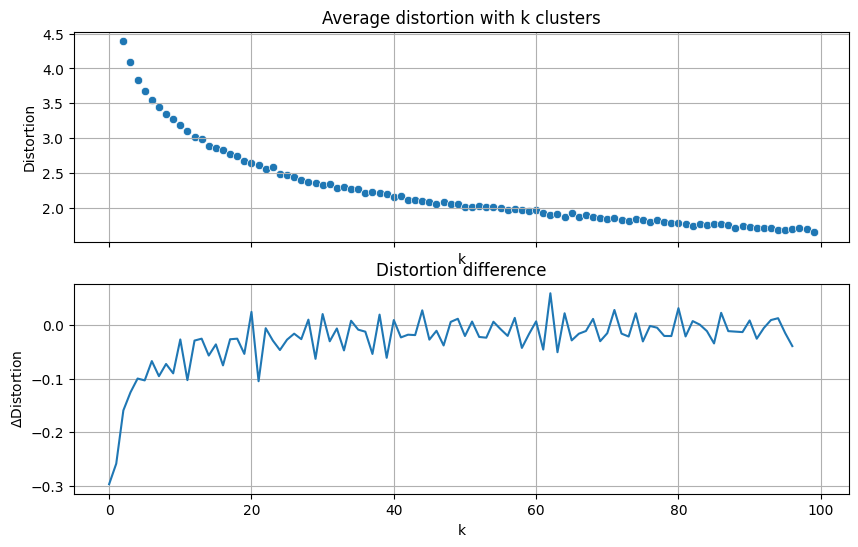

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
fig.set_size_inches(10, 6)


ax1.set_title("Average distortion with k clusters")
ax1.set_ylabel("Distortion")
ax1.set_xlabel("k")

ax2.set_title("Distortion difference")
ax2.set_ylabel("$\Delta$Distortion")
ax2.set_xlabel("k")

ax1.grid()
ax2.grid()

sns.scatterplot(x=map(lambda x: x[0], distortions), y=map(lambda x: x[1], distortions), ax=ax1)
distances = list(map(lambda t: t[1][1] - t[0][1], zip(distortions, distortions[1:])))
sns.lineplot(distances, ax=ax2)

plt.show()

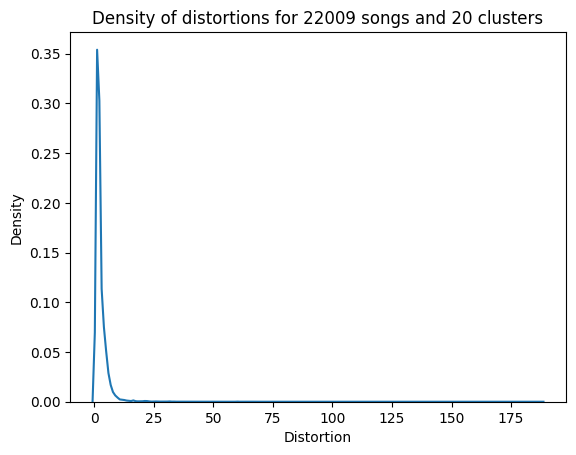

In [17]:
# Set k = 20 clusters, as we see a marginalized distortion difference from there
k = 20
codebook, _ =  scp.kmeans(normalized_observations, k_or_guess=k)
assigned_clusters, obs_distortions = scp.vq(obs=normalized_observations, code_book=codebook)


sns.kdeplot(obs_distortions)
plt.title(f"Density of distortions for {len(obs_distortions)} songs and {k} clusters")
plt.xlabel("Distortion")
plt.show()

In [ ]:
# Assign the clusters to the dataframe and store them in the database


song_structure_df["cluster"] = assigned_clusters
db_columns = ["cluster_id"] + song_structure_df.columns.tolist()
db_columns.remove("cluster")
song_cluster = [
    (int(song_id), int(cluster))
    for song_id, cluster in song_structure_df[["cluster"]].to_records(index=True)
]

data = []
for i, cluster in enumerate(codebook):
    record = [i]
    record.extend(cluster)
    assert len(record) == 43, f"Record has size {len(record)}"
    data.append(record)

cluster_centroids = pd.DataFrame(data, columns=db_columns).set_index("cluster_id")
display(cluster_centroids)

,amt_intro,pos_avg_intro,pos_std_intro,amt_verse,pos_avg_verse,pos_std_verse,amt_pre-chorus,pos_avg_pre-chorus,pos_std_pre-chorus,amt_chorus,...,pos_std_instrumental,amt_vamp,pos_avg_vamp,pos_std_vamp,amt_break,pos_avg_break,pos_std_break,amt_solo,pos_avg_solo,pos_std_solo
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,0.001886,0.000000,0.000000,2.172710,1.264669,1.654850,0.021767,0.016692,0.000000,1.858009,...,0.000000,0.000000,0.000000,0.000000,0.005248,0.001149,0.000000,0.000000,0.000000,0.000000
1,0.957398,0.151864,0.178308,2.210464,1.840663,2.073372,0.787538,0.748719,0.755984,1.282496,...,0.119921,0.000000,0.000000,0.000000,6.661290,6.810084,2.913904,0.046008,0.060704,0.000000
2,0.773955,0.060422,0.060462,2.101325,1.946347,2.305258,3.045804,2.912418,2.874803,1.786392,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.841442,0.101834,0.090580,2.012553,2.026368,2.358551,1.382953,1.496410,1.566655,1.917443,...,0.037694,0.000000,0.000000,0.000000,0.132941,0.237386,0.000000,0.000000,0.000000,0.000000
4,1.011970,0.127861,0.134890,2.438646,2.421472,2.456558,0.064851,0.096780,0.056451,0.838692,...,0.000000,0.000000,0.000000,0.000000,0.021499,0.012555,0.000000,0.000000,0.000000,0.000000
5,1.121426,0.091735,0.099893,2.708680,2.247682,2.179485,0.003489,0.004505,0.002947,0.023023,...,0.000000,0.016245,0.005878,0.000000,0.005949,0.002605,0.000000,0.000000,0.000000,0.000000
6,0.811269,0.032680,0.000000,2.136084,2.148179,2.410550,0.052795,0.071573,0.058134,0.093564,...,0.182793,0.000000,0.000000,0.000000,0.131269,0.132237,0.086274,0.000000,0.000000,0.000000
7,0.867907,0.047725,0.024258,2.136226,1.580973,1.758960,0.063333,0.071342,0.000000,1.889647,...,0.000000,0.000000,0.000000,0.000000,0.021909,0.009596,0.000000,0.008606,0.000000,0.000000
8,0.384078,0.067492,0.000000,2.326386,1.564640,2.248921,0.776873,0.760783,0.805827,1.725736,...,0.038068,0.000000,0.000000,0.000000,0.092950,0.117044,0.000000,9.237812,8.929709,2.257094


## Save to database

In [ ]:
conn, cursor = create_connection("genius_db")
cursor.executemany(
    f"INSERT INTO cluster VALUES ({', '.join(['%s']*43)})",
    [(int(id), *map(float, data)) for id, *data in cluster_centroids.to_records()],
)
conn.commit()
cursor.executemany(
    "INSERT INTO song_cluster (song_id, cluster_id) VALUES (%s,%s)", song_cluster
)
conn.commit()
cursor.executemany(
    f"INSERT INTO song_fingerprint VALUES ({', '.join(['%s']*43)})",
    [(int(id), *map(float, data)) for id, *data in song_structure_df.to_records()],
)
conn.commit()
conn.close()

In [6]:
song_structure_df

,amt_intro,pos_avg_intro,pos_std_intro,amt_verse,pos_avg_verse,pos_std_verse,amt_pre-chorus,pos_avg_pre-chorus,pos_std_pre-chorus,amt_chorus,...,pos_std_instrumental,amt_vamp,pos_avg_vamp,pos_std_vamp,amt_break,pos_avg_break,pos_std_break,amt_solo,pos_avg_solo,pos_std_solo
song_id,,,,,,,,,,,,,,,,,,,,,
0,1,0.0,0.0,3,5.333333,4.189935,0,0.0,0.0,6,...,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
1,0,0.0,0.0,3,2.333333,2.054805,0,0.0,0.0,0,...,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
2,1,0.0,0.0,3,2.666667,1.699673,0,0.0,0.0,2,...,0.0,0,0.0,0.0,1,3.0,0.0,0,0.0,0.0
4,0,0.0,0.0,2,1.000000,1.000000,0,0.0,0.0,0,...,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
5,1,0.0,0.0,3,3.000000,1.632993,0,0.0,0.0,3,...,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11966,0,0.0,0.0,2,2.000000,1.000000,0,0.0,0.0,3,...,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
11981,1,0.0,0.0,2,3.000000,1.000000,0,0.0,0.0,3,...,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
11997,1,0.0,0.0,3,3.000000,1.632993,0,0.0,0.0,0,...,1.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
